# Обнаружение дефектов стали





Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.

### Метрики:

#### коэффициент Дайса:

Коэффициент Дайса можно использовать для сравнения попиксельного согласия между предсказанной сегментацией и соответствующей ей основной истиной. Формула дается::

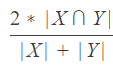


где X — предсказанный набор пикселей, а Y — основная истина. Коэффициент Дайса равен 1, когда X и Y пусты.

### Ограничения

### Закодированные пиксели

Чтобы уменьшить размер отправляемого файла, метрика использует кодирование длины серии для значений пикселей. Вместо предоставления исчерпывающего списка индексов для вашей сегментации мы будем отправлять пары значений, которые содержат начальную позицию и длину серии. Например. «1 3» подразумевает начало с пикселя 1 и прохождение в общей сложности 3 пикселей (1,2,3).

In [6]:
from keras.layers import concatenate
from tensorflow.keras.layers import concatenate

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from tqdm import tqdm_notebook
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import concatenate

# Exploratory Data Analysis

In [12]:
df = pd.read_csv('train.csv')
df.shape

(7095, 3)

In [13]:
from glob import glob

TRAIN_PATH = '/content/train_images/'
TEST_PATH = '/content/test_images/'
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 0 images in the train set.
There are 0 images in the test set.


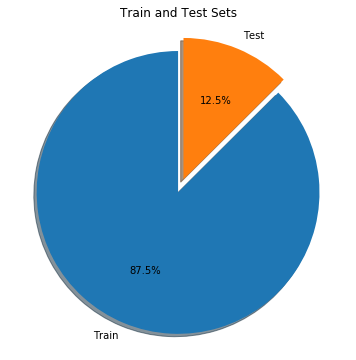

In [ ]:
# построение круговой диаграммы, демонстрирующей наборы поездов и тестов
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

#### Сколько  изображений стали имеют недостатки?

In [ ]:
print("Train_df INFO : \n")
print("1.Number of data points : ", len(df))
print("2.Correct images  : ", df["EncodedPixels"].isna().sum().T)
print("3.Incorrect images : ",len(df) - df["EncodedPixels"].isna().sum().T )

Train_df INFO : 

1.Number of data points :  50272
2.Correct images  :  43177
3.Incorrect images :  7095


#### Около 7095 изображений имеют недостатки

#### Сколько классов присвоено одной фотографии? Это проблема сегментации по одной или нескольким меткам?

In [ ]:
# добавить новые функции из существующих
df["Label"] = df["ImageId_ClassId"].apply(lambda x : x.split("_")[1])
df["Image_id"] = df["ImageId_ClassId"].apply(lambda x : x.split("_")[0])
df.head(2)

,ImageId_ClassId,EncodedPixels,Label,Image_id
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,2,0002cc93b.jpg


In [ ]:
# данные без пропусков
train_df_damaged = df[df["EncodedPixels"].notnull()]
train_df_damaged.head()

,ImageId_ClassId,EncodedPixels,Label,Image_id
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg
18,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...,3,0007a71bf.jpg
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,1,000a4bcdd.jpg
27,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,4,000f6bf48.jpg
30,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...,3,0014fce06.jpg


Numeric info : 

1 class :  6239
2 classes :  425
3 classes :  2
4 classes :  0


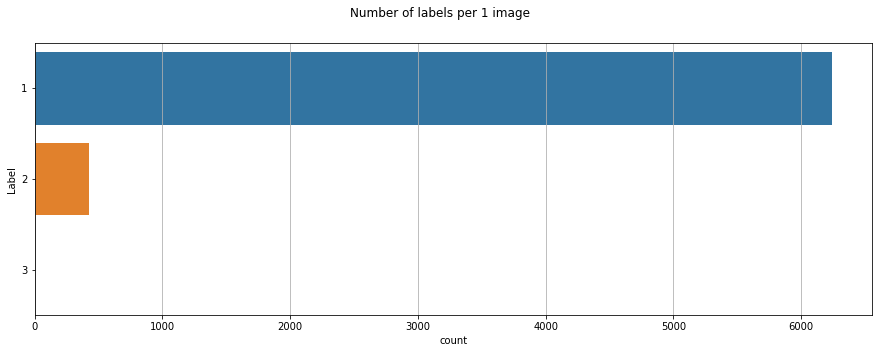

In [ ]:
n_class_per_image =  train_df_damaged["Label"].groupby(train_df_damaged["Image_id"]).count()
plt.figure(figsize=(15,5))
plt.suptitle("Number of labels per 1 image")
plt.grid()
import seaborn as sns
sns.countplot(y=n_class_per_image)
print("Numeric info : \n")
print("1 class : ",len(n_class_per_image[n_class_per_image == 1]))
print("2 classes : ",len(n_class_per_image[n_class_per_image == 2]))
print("3 classes : ",len(n_class_per_image[n_class_per_image == 3]))
print("4 classes : ",len(n_class_per_image[n_class_per_image == 4]))

Большинство количество классов на изображении = 1

Минимум количество классов  на изображении = 3

Макс. количество классов на изображении = 3

В этом контексте мы боремся с сегментацией по нескольким меткам.

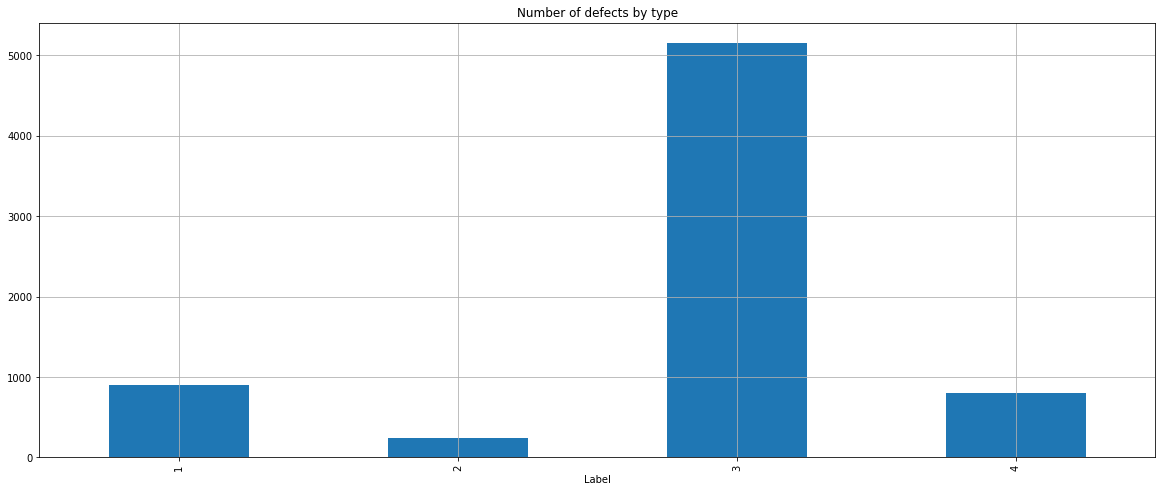

In [ ]:
df.groupby('Label')['EncodedPixels'].count().plot(kind='bar',
                                                            title='Number of defects by type',
                                                            figsize=(20, 8),
                                                            grid=True);

In [ ]:
print('There are {} rows with empty segmentation maps.'.format(len(df) - df.EncodedPixels.count()))

There are 43177 rows with empty segmentation maps.


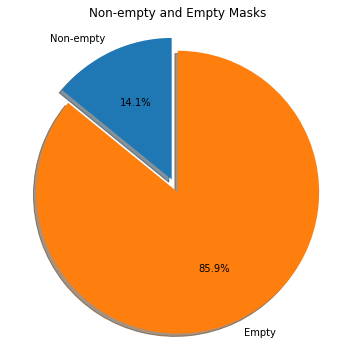

In [ ]:
labels = 'Non-empty', 'Empty'
sizes = [df.EncodedPixels.count(), len(df) - df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

In [ ]:
split_df = df["ImageId_ClassId"].str.split("_", n = 1, expand = True)
df['Image'] = split_df[0]
df['Label'] = split_df[1]
df.head()

,ImageId_ClassId,EncodedPixels,Label,Image_id,Image
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,1,0002cc93b.jpg,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,2,0002cc93b.jpg,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,3,0002cc93b.jpg,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,4,0002cc93b.jpg,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg,00031f466.jpg


In [ ]:
defect1 = df[df['Label'] == '1'].EncodedPixels.count()
defect2 = df[df['Label'] == '2'].EncodedPixels.count()
defect3 = df[df['Label'] == '3'].EncodedPixels.count()
defect4 = df[df['Label'] == '4'].EncodedPixels.count()

print('There are {} defect1 images'.format(defect1))
print('There are {} defect2 images'.format(defect2))
print('There are {} defect3 images'.format(defect3))
print('There are {} defect4 images'.format(defect4))
print('There are {} images with no defects'.format(len(train_fns) - defect1 - defect2 - defect3 - defect4))

There are 897 defect1 images
There are 247 defect2 images
There are 5150 defect3 images
There are 801 defect4 images
There are 5473 images with no defects


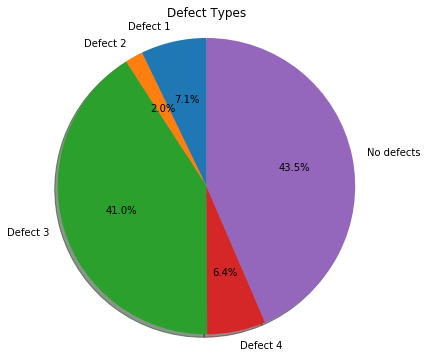

In [ ]:
labels = 'Defect 1', 'Defect 2', 'Defect 3', 'Defect 4', 'No defects'
sizes = [defect1, defect2, defect3, defect4, len(train_fns) - defect1 - defect2 - defect3 - defect4]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')

plt.show()

Выводы:

Набор данных очень несбалансирован.

Для обнаружения дефектов потребуются методы увеличения и повторной выборки данных.

In [ ]:
labels_per_image = df.groupby('Image')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 0.564528962444303


Text(0.5, 1.0, 'Number of Labels per Image')

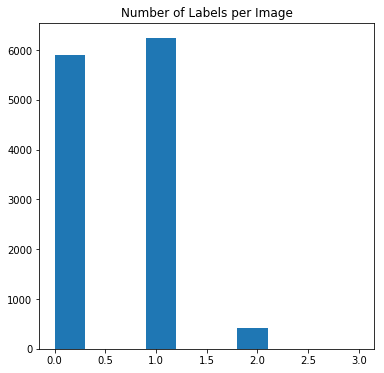

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

#### Выводы:

Почти половина изображений не содержит дефектов;

Большинство изображений с дефектами содержат дефекты только одного типа;

В редких случаях изображение содержит дефекты двух разных типов.

# Подготовка данных

In [ ]:
df['ImageId'] = df['ImageId_ClassId'].map(lambda x : x.split(".")[0]+'.jpg') # This will take id after interval of 4 rows.
train = pd.DataFrame({'ImageId':df['ImageId'][0::4]}) # Creating dataframe with image names of images
train['e1'] = df['EncodedPixels'][0::4].values # Will take encoding after interval of 4.
train['e2'] = df['EncodedPixels'][1::4].values
train['e3'] = df['EncodedPixels'][2::4].values
train['e4'] = df['EncodedPixels'][3::4].values
train.reset_index(inplace=True, drop=True)
train.fillna('', inplace=True)
train.head()

,ImageId,e1,e2,e3,e4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [ ]:
train_df = train.iloc[:int(0.80*len(train))]
test_df = train.iloc[int(0.80*len(train)):int(0.9*len(train))]
cv_df = train.iloc[int(0.9*len(train)):]

In [ ]:
print(train_df.shape)
print(test_df.shape)
print(cv_df.shape)

(10054, 5)
(1257, 5)
(1257, 5)


In [ ]:
import numpy as np
def rle2mask(rle):
  # если rle пустое или нулл
  if(len(rle)<1):
    return np.zeros((128,800) ,dtype=np.uint8)

  height = 256
  width = 1600

  # Определение длины маски. Это будет массив 1d, а позже он будет преобразован в 2d.
  mask = np.zeros(height*width ).astype(np.uint8)
  # У нас будет массив, который будет содержать rle
  array = np.asarray([int(x) for x in rle.split()])
  start = array[0::2]-1 # this willl contain the start of run length
  length = array[1::2] # this will contain the length of each rle.

  # теперь мы изменим значение каждого пикселя в файле на 1.
  for i,start in enumerate(start):
    mask[int(start):int(start+length[i])] = 1

  # теперь мы вернем маску, сначала изменив ее форму, а затем повернув на 90 градусов и перевернув ее вертикально вверх тормашками.
  return mask.reshape( (height,width), order='F' )[::2,::2]

In [ ]:
    def mask2rle(img):
        '''
        img: numpy array, 1 - mask, 0 - background
        Возвращает длину серии в виде строки
        '''
        pixels= img.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

### Аугментация данных

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False,
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info

        if self.subset == "train":
            self.data_path = '/content/' + 'train_images/'
        elif self.subset == "test":
            self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #переворачивание изображений по горизонтали и выборочная нормализация стандарта
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}

        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            if self.subset == 'train':
                #кодирование длин серий значений пикселей
                for j in range(4):
                    mask = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]])
                    y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

In [ ]:
from keras import backend as K
from keras.losses import binary_crossentropy
# расчет коэффицент Дайса
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def  bce_dice_loss(y_true, y_predict):
  return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

# Создание нейронной сети

In [ ]:
    inputs = Input((128,800,3)) # 256
    down = Conv2D(32, (3, 3), padding='same')(inputs)
    down = BatchNormalization()(down)
    down = Activation('relu')(down)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down) #128
    center = Conv2D(128, (3, 3), padding='same')(down_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center) # center
    up = UpSampling2D((2, 2))(center)
    up = concatenate([down, up], axis=3)
    up = Conv2D(32, (3, 3), padding='same')(up)
    up = BatchNormalization()(up)
    up = Activation('relu')(up) # 256
    classify = Conv2D(4, (1, 1), activation='sigmoid')(up)
    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy',dice_coef])










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
train_batches = DataGenerator(train_df,shuffle=True)
valid_batches = DataGenerator(cv_df)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1)

Epoch 1/20
628/628 [==============================] - 388s 619ms/step - loss: 0.0997 - acc: 0.9827 - dice_coef: 0.0321 - val_loss: 0.0410 - val_acc: 0.9928 - val_dice_coef: 0.0212
Epoch 2/20
628/628 [==============================] - 382s 608ms/step - loss: 0.0355 - acc: 0.9922 - dice_coef: 0.0760 - val_loss: 0.0345 - val_acc: 0.9929 - val_dice_coef: 0.0642
Epoch 3/20
628/628 [==============================] - 379s 603ms/step - loss: 0.0327 - acc: 0.9923 - dice_coef: 0.1053 - val_loss: 0.0367 - val_acc: 0.9918 - val_dice_coef: 0.0938
Epoch 4/20
628/628 [==============================] - 379s 604ms/step - loss: 0.0314 - acc: 0.9924 - dice_coef: 0.1254 - val_loss: 0.0299 - val_acc: 0.9931 - val_dice_coef: 0.1306
Epoch 5/20
628/628 [==============================] - 383s 609ms/step - loss: 0.0307 - acc: 0.9925 - dice_coef: 0.1354 - val_loss: 0.0296 - val_acc: 0.9931 - val_dice_coef: 0.1336
Epoch 6/20
628/628 [==============================] - 380s 606ms/step - loss: 0.0302 - acc: 0.9925 -

In [ ]:
from keras.models import load_model

model.save('model1.h5')

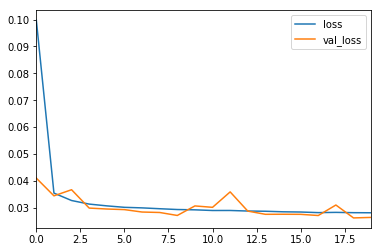

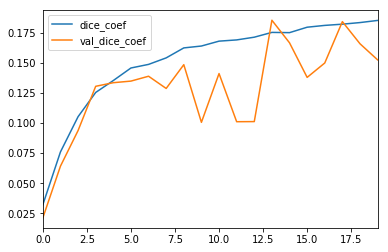

In [ ]:
import json
with open('history.json','w') as f:
  json.dump(history.history, f)
  history_df = pd.DataFrame(history.history)
  history_df[['loss', 'val_loss']].plot()
  history_df[['dice_coef', 'val_dice_coef']].plot()

In [ ]:
test_batches = DataGenerator(test_df, subset='test',batch_size=1)
preds = model.predict_generator(test_batches,verbose=1)

1257/1257 [==============================] - 25s 20ms/step


In [ ]:
# Предсказание теста
from tqdm import tqdm
data_path = '/content/' + 'test_images/'
files = list(os.listdir(data_path))
img_classId = []
rle_lst = []
for f in files:
  X = np.empty((1,128,800,3),dtype=np.float32)
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  X[0,] = img
  mask = model.predict(X)
  rle_m = np.empty((128,800),dtype=np.uint8)
  for i in range(4):
    rle_m = mask[0,:,:,i].round().astype(int)
    rle = mask2rle(rle_m)
    rle_lst.append(rle)
    img_classId.append(f+'_'+str(i+1))

In [ ]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission.csv', index=False)

# Заключение


классифицировали тип дефекта стали, сегментировали части изображения, содержащие дефект, и достигли коэффициента Дайса менее 0,09.